In [1]:
pip install nfl_data_py pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [71]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import urllib.request
import numpy as np

sns.set(style="whitegrid", font_scale=1.2)

In [3]:
# List available columns so you always know what's actually present
pbp_cols = nfl.see_pbp_cols()
print("First 20 columns:", pbp_cols[:20])

First 20 columns: Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       'side_of_field', 'yardline_100', 'game_date',
       'quarter_seconds_remaining', 'half_seconds_remaining',
       'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp'],
      dtype='object')


In [40]:
years = list(range(2022, 2025))
cols = [
    "season", "week", "game_id", "posteam", "defteam", "down", "ydstogo", "yardline_100", "play_type",
    "epa", "desc", "play_id", "pass", "rush", "success", "third_down_converted", "third_down_failed", "fourth_down_converted", "fourth_down_failed"
]
pbp = nfl.import_pbp_data(years, columns=cols)
print(f"Loaded plays: {len(pbp):,}")
pbp = pbp.dropna(subset=['down', 'play_type'])
pbp['down'] = pbp['down'].astype(int)

2022 done.
2023 done.
2024 done.
Downcasting floats.
Loaded plays: 148,591


In [41]:
# Step 1: Filter to plays of interest
useful_pbp = pbp[
    pbp['season'].between(2022, 2024) &
    pbp['play_type'].isin(['pass', 'run'])
].copy()

# Step 2: Create distance bucket column
def distance_bucket(dist):
    if 1 <= dist <= 3:
        return 'short'
    elif 4 <= dist <= 7:
        return 'medium'
    elif 8 <= dist <= 10:
        return 'long'
    elif dist >= 11:
        return 'very long'
    else:
        return 'other'
useful_pbp['distance_bucket'] = useful_pbp['ydstogo'].apply(distance_bucket)

# Exclude any other distances
useful_pbp = useful_pbp[useful_pbp['distance_bucket'] != 'other']

# Step 3: Group and aggregate counts
agg = (
    useful_pbp.groupby(
        ['season', 'posteam', 'down', 'distance_bucket', 'play_type']
    )['play_id'].count()
    .unstack(fill_value=0)
    .reset_index()
)

# Handle possible missing columns after unstack
if 'pass' not in agg: agg['pass'] = 0
if 'run' not in agg: agg['run'] = 0

agg['total'] = agg['pass'] + agg['run']
agg['pass_pct'] = agg['pass'] / agg['total']
agg['run_pct']  = agg['run'] / agg['total']

# Ensure the output directory exists
output_dir = "NFL_Team_play_type_frequency_charts"
os.makedirs(output_dir, exist_ok=True)

distance_buckets = ['short', 'medium', 'long', 'very long']
downs = [1, 2, 3, 4]
play_types = ['pass', 'run']
colors = {'pass': 'blue', 'run': 'orange'}

for team in sorted(agg['posteam'].unique()):
    team_dir = os.path.join(output_dir, team)
    os.makedirs(team_dir, exist_ok=True)
    pdf_path = os.path.join(team_dir, f"{team}_2022_2024_pass_run_by_down_and_distance.pdf")
    with PdfPages(pdf_path) as pdf:
        for year in [2022, 2023, 2024]:
            year_df = agg[(agg['posteam'] == team) & (agg['season'] == year)]
            all_bar_names = []
            all_values = []
            all_colors = []
            # Build y-tick labels: Down - Distance - PlayType
            for dn in downs:
                for bucket in distance_buckets:
                    for pt in play_types:
                        label = f"D{dn}-{bucket}-{pt}"
                        row = year_df[(year_df['down']==dn) & (year_df['distance_bucket']==bucket)]
                        value = row[f"{pt}_pct"].iloc[0] if not row.empty else 0
                        all_bar_names.append(label)
                        all_values.append(value)
                        all_colors.append(colors[pt])
            fig, ax = plt.subplots(figsize=(10, 18))
            y = range(len(all_bar_names))
            bars = ax.barh(y, all_values, color=all_colors)
            # Add labels for every bar
            ax.set_yticks(y)
            ax.set_yticklabels(all_bar_names, fontsize=10)
            ax.set_xlim(0, 1)
            ax.set_ylabel("Down - Distance Bucket - Play Type")
            ax.set_xlabel("Percentage")
            ax.set_title(f"{team} {year}: Pass/Run Frequency by Down & Distance (Horizontal Bars)")
            from matplotlib.patches import Patch
            legend_handles = [Patch(color=colors[pt], label=pt.capitalize()) for pt in play_types]
            ax.legend(handles=legend_handles, title="Play Type", loc='lower right')
            plt.tight_layout()
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)
    print(f"Saved: {pdf_path}")

Saved: NFL_Team_play_type_frequency_charts\ARI\ARI_2022_2024_pass_run_by_down_and_distance.pdf
Saved: NFL_Team_play_type_frequency_charts\ATL\ATL_2022_2024_pass_run_by_down_and_distance.pdf
Saved: NFL_Team_play_type_frequency_charts\BAL\BAL_2022_2024_pass_run_by_down_and_distance.pdf
Saved: NFL_Team_play_type_frequency_charts\BUF\BUF_2022_2024_pass_run_by_down_and_distance.pdf
Saved: NFL_Team_play_type_frequency_charts\CAR\CAR_2022_2024_pass_run_by_down_and_distance.pdf
Saved: NFL_Team_play_type_frequency_charts\CHI\CHI_2022_2024_pass_run_by_down_and_distance.pdf
Saved: NFL_Team_play_type_frequency_charts\CIN\CIN_2022_2024_pass_run_by_down_and_distance.pdf
Saved: NFL_Team_play_type_frequency_charts\CLE\CLE_2022_2024_pass_run_by_down_and_distance.pdf
Saved: NFL_Team_play_type_frequency_charts\DAL\DAL_2022_2024_pass_run_by_down_and_distance.pdf
Saved: NFL_Team_play_type_frequency_charts\DEN\DEN_2022_2024_pass_run_by_down_and_distance.pdf
Saved: NFL_Team_play_type_frequency_charts\DET\DET

In [37]:
# Prepare a long-form DataFrame if agg is in wide format
agg_long = agg.melt(
    id_vars=['posteam', 'down', 'distance_bucket', 'season'],
    value_vars=['pass_pct', 'run_pct'],
    var_name='Play_Type',
    value_name='Pct'
)
agg_long['Play_Type'] = agg_long['Play_Type'].str.replace('_pct', '').str.capitalize()

# Pivot so each year is a column for easier percent change calculation
pivot = agg_long.pivot_table(
    index=['posteam', 'down', 'distance_bucket', 'Play_Type'],
    columns='season', values='Pct'
).reset_index().rename_axis(None, axis=1)

# Compute percent change columns (in percent points)
pivot['2022->2023 Δ'] = (pivot[2023] - pivot[2022]) * 100
pivot['2023->2024 Δ'] = (pivot[2024] - pivot[2023]) * 100

# format columns for clearer display (as percentage strings)
for year in [2022, 2023, 2024]:
    pivot[year] = (pivot[year] * 100).round(1).astype(str) + '%'
pivot['2022->2023 Δ'] = pivot['2022->2023 Δ'].round(1).astype(str) + ' %'
pivot['2023->2024 Δ'] = pivot['2023->2024 Δ'].round(1).astype(str) + ' %'

# Rename for clarity
pivot = pivot.rename(columns={
    "posteam": "Team",
    "down": "Down",
    "distance_bucket": "Distance Bucket",
    "Play_Type": "Play Type",
    2022: "2022 %", 2023: "2023 %", 2024: "2024 %",
    "2022->2023 Δ": "2022→2023 Change",
    "2023->2024 Δ": "2023→2024 Change"
})

output_path = os.path.join(output_dir, "team_playcalling_rate_trends.csv")
pivot.to_csv(output_path, index=False)

In [51]:
print(final_with_totals.columns.tolist())

['Success Rate %_2022', 'Success Rate %_2023', 'Success Rate %_2024', 'Success Rate %_2022→2023 Δ', 'Success Rate %_2023→2024 Δ', 'Conversion %_2022', 'Conversion %_2023', 'Conversion %_2024', 'Conversion %_2022→2023 Δ', 'Conversion %_2023→2024 Δ', 'Conversion % Total_2022', 'Conversion % Total_2023', 'Conversion % Total_2024', 'Conversion % Total_2022→2023 Δ', 'Conversion % Total_2023→2024 Δ', 'n_plays_total_2022', 'n_plays_total_2023', 'n_plays_total_2024']


In [53]:
# Use your existing filtered play data (ensure these columns exist)
df = useful_pbp.copy()

def conversion_flag(row):
    if row['down'] == 3:
        return row['third_down_converted']
    elif row['down'] == 4:
        return row['fourth_down_converted']
    else:
        return None
df['conversion'] = df.apply(conversion_flag, axis=1)

# Detailed by down/distance/play type
group_cols = ['posteam', 'down', 'distance_bucket', 'play_type', 'season']
summary = (
    df.groupby(group_cols)
      .agg(
          n_plays=('play_id', 'count'),
          n_successes=('success', 'sum'),
          n_conversions=('conversion', lambda x: x.dropna().sum())
      )
      .reset_index()
)
summary['Success Rate %'] = (summary['n_successes'] / summary['n_plays']).round(4) * 100
summary['Conversion %'] = (summary['n_conversions'] / summary['n_plays']).round(4) * 100

final = summary.pivot_table(
    index=['posteam', 'down', 'distance_bucket', 'play_type'],
    columns='season', values=['n_plays', 'Success Rate %', 'Conversion %']
).reset_index()

# flatten columns but keep original names
final.columns = ['_'.join([str(i) for i in col if i not in ('',)]) for col in final.columns.values]

# Calculate year-over-year percent point change
for metric in ['Success Rate %', 'Conversion %']:
    final[f"{metric}_2022→2023 Δ"] = (final[f"{metric}_2023"] - final[f"{metric}_2022"]).round(1)
    final[f"{metric}_2023→2024 Δ"] = (final[f"{metric}_2024"] - final[f"{metric}_2023"]).round(1)

# Team-level 3rd/4th down conversion %
agg_down = (
    df[df['down'].isin([3,4])]
    .groupby(['posteam', 'down', 'season'])
    .agg(
        n_plays=('play_id', 'count'),
        n_conversions=('conversion', lambda x: x.dropna().sum())
    )
    .reset_index()
)
agg_down['Conversion %'] = (agg_down['n_conversions'] / agg_down['n_plays']).round(4) * 100

pivot_down = agg_down.pivot_table(
    index=['posteam', 'down'],
    columns='season',
    values=['n_plays', 'Conversion %']
).reset_index()
pivot_down.columns = ['_'.join([str(i) for i in col if i not in ('',)]) for col in pivot_down.columns.values]

pivot_down['Conversion %_2022→2023 Δ'] = (
    pivot_down['Conversion %_2023'] - pivot_down['Conversion %_2022']
).round(1)
pivot_down['Conversion %_2023→2024 Δ'] = (
    pivot_down['Conversion %_2024'] - pivot_down['Conversion %_2023']
).round(1)

# Add empty "distance_bucket" and "play_type" columns so .concat works
pivot_down['distance_bucket'] = ''
pivot_down['play_type'] = ''

# Reorder for output; all columns in both dfs
ordered_cols = [
    'posteam', 'down', 'distance_bucket', 'play_type',
    'n_plays_2022', 'n_plays_2023', 'n_plays_2024',
    'Success Rate %_2022', 'Success Rate %_2023', 'Success Rate %_2024',
    'Success Rate %_2022→2023 Δ', 'Success Rate %_2023→2024 Δ',
    'Conversion %_2022', 'Conversion %_2023', 'Conversion %_2024',
    'Conversion %_2022→2023 Δ', 'Conversion %_2023→2024 Δ',
]
# Add missing cols as needed for totals
for col in ordered_cols:
    if col not in final.columns:
        final[col] = ''
for col in ordered_cols:
    if col not in pivot_down.columns:
        pivot_down[col] = ''

# concat and order
combined = pd.concat([final[ordered_cols], pivot_down[ordered_cols]], ignore_index=True)

# Save/output CSV file to your specified directory
output_dir = "NFL_Team_play_type_frequency_charts"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "team_playcalling_conversion_success_trends.csv")
combined.to_csv(output_path, index=False)

In [56]:
# Load your existing combined file
output_dir = "NFL_Team_play_type_frequency_charts"
combined = pd.read_csv(os.path.join(output_dir, "team_playcalling_conversion_success_trends.csv"))

# Ensure numeric (some columns may be '' strings for totals/detailed rows)
for metric in ['Success Rate %', 'Conversion %']:
    for year in [2022, 2023, 2024]:
        col = f"{metric}_{year}"
        if col in combined.columns:
            combined[col] = pd.to_numeric(combined[col], errors='coerce')

# ---- 1. Top 10 teams by overall Success Rate % per year (all detailed rows) ----
detailed = combined[(combined['distance_bucket'].notna()) & (combined['distance_bucket'] != '')]
for year in [2022, 2023, 2024]:
    sr_col = f"Success Rate %_{year}"
    n_col = f"n_plays_{year}"
    # Weighted average by team
    sr_by_team = (detailed
        .groupby('posteam')
        .apply(lambda df_: (df_[sr_col]*df_[n_col]).sum() / df_[n_col].sum() if df_[n_col].sum() > 0 else pd.NA)
        .reset_index(name=sr_col)
        .sort_values(sr_col, ascending=False)
        .dropna(subset=[sr_col])
    )
    print(f"\nTop 10 teams by Success Rate % in {year}:")
    display(sr_by_team[['posteam', sr_col]].head(10))

# ---- 2. Top 10 teams by Conversion % for 3rd/4th down per year ----
# Use your existing filtered DataFrame with conversion column
df = useful_pbp.copy()
def conversion_flag(row):
    if row['down'] == 3:
        return row['third_down_converted']
    elif row['down'] == 4:
        return row['fourth_down_converted']
    else:
        return None
df['conversion'] = df.apply(conversion_flag, axis=1)

# Group by team, down, year (for 3rd and 4th downs only)
conv_summary = (
    df[df['down'].isin([3,4])]
    .groupby(['posteam', 'down', 'season'])
    .agg(
        n_plays=('play_id', 'count'),
        n_conversions=('conversion', lambda x: x.dropna().sum())
    )
    .reset_index()
)
conv_summary['Conversion %'] = (conv_summary['n_conversions'] / conv_summary['n_plays'] * 100).round(2)

# Show all team/year combinations for 3rd and 4th down
for dn in [3,4]:
    for year in [2022, 2023, 2024]:
        temp = conv_summary[(conv_summary['down'] == dn) & (conv_summary['season'] == year)]
        if not temp.empty:
            ordinal = '3rd' if dn == 3 else '4th'
            print(f"\nTop 10 teams by {ordinal} down Conversion % in {year}:")
            display(temp.sort_values('Conversion %', ascending=False)[['posteam', 'Conversion %', 'n_plays']].head(10))
        else:
            ordinal = '3rd' if dn == 3 else '4th'
            print(f"\nNo {ordinal} down conversion data for {year} (no attempts by any team).")


Top 10 teams by Success Rate % in 2022:


,posteam,Success Rate %_2022
15,KC,50.316133
25,PHI,48.357341
3,BUF,48.345618
6,CIN,47.688936
14,JAX,46.800421
28,SF,45.795712
11,GB,45.692836
22,NO,45.555115
10,DET,45.445976
1,ATL,45.335918



Top 10 teams by Success Rate % in 2023:


,posteam,Success Rate %_2023
28,SF,50.251309
3,BUF,49.431661
8,DAL,47.896785
10,DET,46.967038
2,BAL,46.919992
19,MIA,46.477466
25,PHI,45.194805
11,GB,44.868583
16,LA,44.648737
6,CIN,43.937391



Top 10 teams by Success Rate % in 2024:


,posteam,Success Rate %_2024
10,DET,50.517315
2,BAL,50.343339
29,TB,49.600409
1,ATL,48.082049
3,BUF,47.910927
31,WAS,47.691008
15,KC,47.342020
6,CIN,47.281557
0,ARI,47.270117
16,LA,46.629974



Top 10 teams by 3rd down Conversion % in 2022:


,posteam,Conversion %,n_plays
18,BUF,51.15,217
90,KC,49.33,225
150,PHI,47.94,267
36,CIN,47.30,241
48,DAL,45.35,258
168,SF,45.27,243
156,PIT,44.92,236
102,LAC,44.12,272
6,ATL,42.49,193
84,JAX,41.77,237



Top 10 teams by 3rd down Conversion % in 2023:


,posteam,Conversion %,n_plays
49,DAL,50.00,242
19,BUF,49.59,244
67,GB,48.16,245
169,SF,47.49,219
151,PHI,46.55,232
91,KC,44.12,272
61,DET,42.52,254
97,LA,42.06,233
175,TB,41.86,258
31,CHI,41.35,237



Top 10 teams by 3rd down Conversion % in 2024:


,posteam,Conversion %,n_plays
14,BAL,50.93,214
176,TB,50.88,226
92,KC,48.24,255
62,DET,47.42,213
38,CIN,46.73,214
20,BUF,45.15,237
188,WAS,45.04,262
2,ARI,43.23,192
170,SF,42.86,196
152,PHI,41.01,278



Top 10 teams by 4th down Conversion % in 2022:


,posteam,Conversion %,n_plays
99,LA,78.95,19
93,KC,76.92,13
159,PIT,73.33,15
153,PHI,72.97,37
51,DAL,60.87,23
165,SEA,59.09,22
27,CAR,57.14,21
45,CLE,54.76,42
111,LV,54.17,24
63,DET,54.05,37



Top 10 teams by 4th down Conversion % in 2023:


,posteam,Conversion %,n_plays
16,BAL,70.59,17
154,PHI,67.86,28
178,TB,66.67,21
58,DEN,65.00,20
100,LA,63.64,22
112,LV,60.87,23
124,MIN,60.71,28
22,BUF,60.00,20
148,NYJ,58.62,29
172,SF,57.14,14



Top 10 teams by 4th down Conversion % in 2024:


,posteam,Conversion %,n_plays
191,WAS,78.95,38
23,BUF,74.19,31
155,PHI,70.97,31
65,DET,68.57,35
11,ATL,67.74,31
59,DEN,66.67,24
95,KC,66.67,21
101,LA,65.38,26
179,TB,64.29,14
77,HOU,61.90,21


In [58]:
# Define the years and columns you want
years = list(range(2022, 2025))
cols = [
    "season", "week", "game_id", "posteam", "defteam", "down", "ydstogo", "yardline_100",
    "play_type", "epa", "desc", "play_id", "pass", "rush", "success",
    "third_down_converted", "third_down_failed", "fourth_down_converted", "fourth_down_failed"
]

# Load the play-by-play data using your NFL data interface. Adjust accordingly if it's nflfastR, nflverse, or another package.
pbp = nfl.import_pbp_data(years, columns=cols)
print(f"Loaded plays: {len(pbp):,}")

# Drop plays missing a down or play_type to keep only valid offensive plays.
pbp = pbp.dropna(subset=['down', 'play_type'])
pbp['down'] = pbp['down'].astype(int)

# (Optional) Preview data
print(pbp.head())

2022 done.
2023 done.
2024 done.
Downcasting floats.
Loaded plays: 148,591
   week          game_id posteam defteam  down  ydstogo  yardline_100  \
2     1  2022_01_BAL_NYJ     NYJ     BAL     1     10.0          78.0   
3     1  2022_01_BAL_NYJ     NYJ     BAL     1     10.0          59.0   
4     1  2022_01_BAL_NYJ     NYJ     BAL     2     10.0          59.0   
5     1  2022_01_BAL_NYJ     NYJ     BAL     3      5.0          54.0   
6     1  2022_01_BAL_NYJ     NYJ     BAL     4     15.0          64.0   

  play_type       epa                                               desc  ...  \
2       run  1.468819  (14:56) 32-Mi.Carter left end to NYJ 41 for 19...  ...   
3      pass -0.492192  (14:29) (No Huddle, Shotgun) 19-J.Flacco pass ...  ...   
4       run -0.325931  (14:25) (No Huddle) 32-Mi.Carter left end to N...  ...   
5      pass -2.402200  (14:01) (No Huddle, Shotgun) 19-J.Flacco pass ...  ...   
6      punt -0.231632  (13:53) 7-B.Mann punts 45 yards to BAL 19, Cen...  ...   


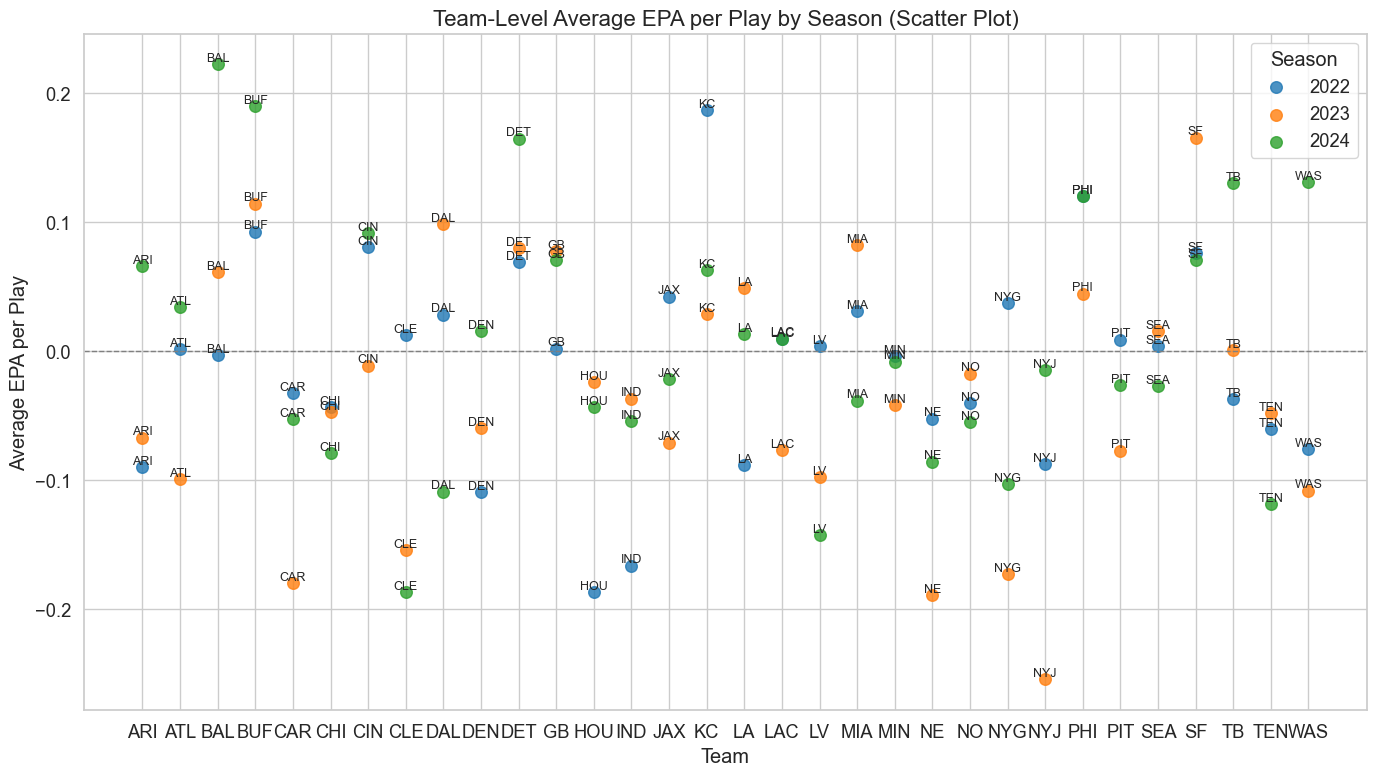

In [60]:
# Calculate EPA per play for each team and season
epa_df = pbp[pbp['play_type'].isin(['run', 'pass'])].copy()
team_epa = (
    epa_df.groupby(['season', 'posteam'])['epa']
    .mean()
    .reset_index()
    .rename(columns={'posteam':'team', 'epa':'avg_epa_per_play'})
)

plt.figure(figsize=(14, 8))

seasons = sorted(team_epa['season'].unique())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # You can edit colors per season if needed

for i, season in enumerate(seasons):
    season_df = team_epa[team_epa['season'] == season]
    plt.scatter(
        season_df['team'],
        season_df['avg_epa_per_play'],
        label=str(season),
        color=colors[i % len(colors)],
        s=70, alpha=0.8
    )
    # label each dot
    for idx, row in season_df.iterrows():
        plt.text(
            row['team'],
            row['avg_epa_per_play'],
            row['team'],
            fontsize=9,
            ha='center',
            va='bottom'
        )

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Team-Level Average EPA per Play by Season (Scatter Plot)", fontsize=16)
plt.xlabel("Team")
plt.ylabel("Average EPA per Play")
plt.legend(title="Season", loc='upper right')
plt.tight_layout()
plt.show()

In [62]:
# Filter to actual pass/run plays only
epa_df = pbp[pbp['play_type'].isin(['pass', 'run'])].copy()

# Group by season, team, play_type—calculate average EPA per play
epa_by_type = (
    epa_df.groupby(['season', 'posteam', 'play_type'])['epa']
    .mean()
    .reset_index()
    .rename(columns={'posteam': 'team', 'epa': 'avg_epa_per_play'})
)

# --- Top Teams by Passing EPA per Play ---
for year in sorted(epa_by_type['season'].unique()):
    print(f"\nTop 10 passing teams by EPA/play in {year}:")
    passing = epa_by_type[
        (epa_by_type['season'] == year) & (epa_by_type['play_type'] == 'pass')
    ].sort_values('avg_epa_per_play', ascending=False)
    display(passing[['team', 'avg_epa_per_play']].head(10))

# --- Top Teams by Rushing EPA per Play ---
for year in sorted(epa_by_type['season'].unique()):
    print(f"\nTop 10 rushing teams by EPA/play in {year}:")
    rushing = epa_by_type[
        (epa_by_type['season'] == year) & (epa_by_type['play_type'] == 'run')
    ].sort_values('avg_epa_per_play', ascending=False)
    display(rushing[['team', 'avg_epa_per_play']].head(10))

# Ensure output directory exists
output_dir = "NFL_Team_play_type_frequency_charts"
os.makedirs(output_dir, exist_ok=True)

# Prepare data
epa_df = pbp[pbp['play_type'].isin(['pass', 'run'])].copy()
epa_by_type = (
    epa_df.groupby(['season', 'posteam', 'play_type'])['epa']
    .mean()
    .reset_index()
    .rename(columns={'posteam': 'team', 'epa': 'avg_epa_per_play'})
)

season_colors = {2022: '#1f77b4', 2023: '#ff7f0e', 2024: '#2ca02c'}

save_path = os.path.join(output_dir, 'epa_per_play_pass_rush_by_team_by_season.pdf')

with PdfPages(save_path) as pdf:
    for play_type in ['pass', 'run']:
        plt.figure(figsize=(16, 8))
        for year in sorted(epa_by_type['season'].unique()):
            temp = epa_by_type[(epa_by_type['season'] == year) & (epa_by_type['play_type'] == play_type)]
            plt.scatter(temp['team'], temp['avg_epa_per_play'], 
                        color=season_colors[year], label=str(year), s=60, alpha=0.8)
            for _, row in temp.iterrows():
                plt.text(row['team'], row['avg_epa_per_play'], row['team'], fontsize=8, ha='center', va='bottom')
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)
        plt.title(f"Average EPA per Play: {play_type.title()} (by Team/Season)", fontsize=14)
        plt.xlabel("Team")
        plt.ylabel("Avg EPA per Play")
        plt.legend(title='Season', loc='best')
        plt.tight_layout()
        pdf.savefig()
        plt.close()

print(f"Scatter plots for pass and run EPA per play by team and season have been saved to:\n{save_path}")


Top 10 passing teams by EPA/play in 2022:


,team,avg_epa_per_play
30,KC,0.254878
56,SF,0.174413
20,DET,0.159840
12,CIN,0.118619
6,BUF,0.099158
50,PHI,0.094711
28,JAX,0.085477
38,MIA,0.062084
16,DAL,0.060256
40,MIN,0.047518



Top 10 passing teams by EPA/play in 2023:


,team,avg_epa_per_play
120,SF,0.255204
86,GB,0.160211
80,DAL,0.139692
102,MIA,0.136310
84,DET,0.133125
70,BUF,0.121810
96,LA,0.080127
122,TB,0.075377
68,BAL,0.067155
114,PHI,0.061370



Top 10 passing teams by EPA/play in 2024:


,team,avg_epa_per_play
132,BAL,0.330590
134,BUF,0.247070
148,DET,0.245767
186,TB,0.193908
140,CIN,0.146521
190,WAS,0.140988
178,PHI,0.134802
184,SF,0.115746
150,GB,0.113333
158,KC,0.083320



Top 10 rushing teams by EPA/play in 2022:


,team,avg_epa_per_play
51,PHI,0.146937
11,CHI,0.103506
47,NYG,0.093887
7,BUF,0.082768
31,KC,0.074503
15,CLE,0.065558
5,BAL,0.048427
23,GB,0.040787
53,PIT,0.034954
9,CAR,0.031281



Top 10 rushing teams by EPA/play in 2023:


,team,avg_epa_per_play
71,BUF,0.105383
121,SF,0.064061
69,BAL,0.054989
65,ARI,0.052001
75,CHI,0.046145
81,DAL,0.035792
115,PHI,0.023769
97,LA,0.007612
85,DET,0.007526
103,MIA,0.007161



Top 10 rushing teams by EPA/play in 2024:


,team,avg_epa_per_play
135,BUF,0.128691
133,BAL,0.127012
191,WAS,0.120012
179,PHI,0.107791
149,DET,0.071035
129,ARI,0.054010
187,TB,0.049602
159,KC,0.031447
151,GB,0.028246
137,CAR,0.016536


Scatter plots for pass and run EPA per play by team and season have been saved to:
NFL_Team_play_type_frequency_charts\epa_per_play_pass_rush_by_team_by_season.pdf


In [76]:
output_dir = "NFL_Team_play_type_frequency_charts"
plot_dir = os.path.join(output_dir, "EPA_per_play_vs_Success_Rate_plots")
os.makedirs(plot_dir, exist_ok=True)

# Only run/play
pbp_filtered = pbp[pbp['play_type'].isin(['pass', 'run'])].copy()
pbp_filtered = pbp_filtered.dropna(subset=['epa', 'success', 'play_id', 'down'])
pbp_filtered['down'] = pbp_filtered['down'].astype(int)

summary = (
    pbp_filtered
    .groupby(['posteam', 'season', 'down'])
    .agg(
        avg_epa_per_play=('epa', 'mean'),
        success_rate=('success', 'mean'),
        n_plays=('play_id', 'count')
    )
    .reset_index()
)

unique_downs = sorted(summary['down'].unique())
unique_seasons = sorted(summary['season'].unique())

for down in unique_downs:
    plt.figure(figsize=(11, 8))
    for season in unique_seasons:
        df_season_down = summary[(summary['season'] == season) & (summary['down'] == down)]
        plt.scatter(
            df_season_down['success_rate'] * 100,
            df_season_down['avg_epa_per_play'],
            s=df_season_down['n_plays'],
            alpha=0.7,
            label=f'Season {season}'
        )
        # Team label for every point
        for _, row in df_season_down.iterrows():
            plt.text(
                row['success_rate'] * 100,
                row['avg_epa_per_play'],
                row['posteam'],
                fontsize=9,
                ha='center',
                va='bottom'
            )
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title(f"EPA per Play vs Success Rate — Down {down}")
    plt.xlabel("Success Rate (%)")
    plt.ylabel("Avg EPA per Play")
    plt.legend(title="Season")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(plot_dir, f"EPA_vs_SuccessRate_Down{down}.png")
    plt.savefig(save_path)
    plt.close()
    print(f"Saved: {save_path}")

Saved: NFL_Team_play_type_frequency_charts\EPA_per_play_vs_Success_Rate_plots\EPA_vs_SuccessRate_Down1.png
Saved: NFL_Team_play_type_frequency_charts\EPA_per_play_vs_Success_Rate_plots\EPA_vs_SuccessRate_Down2.png
Saved: NFL_Team_play_type_frequency_charts\EPA_per_play_vs_Success_Rate_plots\EPA_vs_SuccessRate_Down3.png
Saved: NFL_Team_play_type_frequency_charts\EPA_per_play_vs_Success_Rate_plots\EPA_vs_SuccessRate_Down4.png


In [77]:
# Prepare output folder
output_dir = "NFL_Team_play_type_frequency_charts"
plot_dir = os.path.join(output_dir, "EPA_per_play_vs_Explosive_Play_Rate_plots")
os.makedirs(plot_dir, exist_ok=True)

# Prepare data
pbp_filtered = pbp[pbp['play_type'].isin(['pass', 'run'])].copy()
pbp_filtered = pbp_filtered.dropna(subset=['epa', 'success', 'play_id', 'down'])
pbp_filtered['down'] = pbp_filtered['down'].astype(int)
pbp_filtered['explosive'] = pbp_filtered['epa'] > 1.0

summary = (
    pbp_filtered
    .groupby(['posteam', 'season', 'down'])
    .agg(
        avg_epa_per_play=('epa', 'mean'),
        explosive_play_rate=('explosive', 'mean'),
        n_plays=('play_id', 'count')
    )
    .reset_index()
)

unique_downs = sorted(summary['down'].unique())
unique_seasons = sorted(summary['season'].unique())

for down in unique_downs:
    plt.figure(figsize=(11, 8))
    for season in unique_seasons:
        df_season_down = summary[(summary['season'] == season) & (summary['down'] == down)]
        plt.scatter(
            df_season_down['explosive_play_rate'] * 100,
            df_season_down['avg_epa_per_play'],
            s=df_season_down['n_plays'],
            alpha=0.7,
            label=f'Season {season}'
        )
        for _, row in df_season_down.iterrows():
            plt.text(
                row['explosive_play_rate'] * 100,
                row['avg_epa_per_play'],
                row['posteam'],
                fontsize=9,
                ha='center',
                va='bottom'
            )
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title(f"EPA per Play vs Explosive Play Rate — Down {down}")
    plt.xlabel("Explosive Play Rate (%)")
    plt.ylabel("Avg EPA per Play")
    plt.legend(title="Season")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(plot_dir, f"EPA_vs_ExplosiveRate_Down{down}.png")
    plt.savefig(save_path)
    plt.close()
    print(f"Saved: {save_path}")

Saved: NFL_Team_play_type_frequency_charts\EPA_per_play_vs_Explosive_Play_Rate_plots\EPA_vs_ExplosiveRate_Down1.png
Saved: NFL_Team_play_type_frequency_charts\EPA_per_play_vs_Explosive_Play_Rate_plots\EPA_vs_ExplosiveRate_Down2.png
Saved: NFL_Team_play_type_frequency_charts\EPA_per_play_vs_Explosive_Play_Rate_plots\EPA_vs_ExplosiveRate_Down3.png
Saved: NFL_Team_play_type_frequency_charts\EPA_per_play_vs_Explosive_Play_Rate_plots\EPA_vs_ExplosiveRate_Down4.png
